In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras as keras
from gensim.models.keyedvectors import KeyedVectors
from tensorflow.keras import layers as tfkl
from tensorflow_probability import edward2 as ed
import datetime
from sklearn.model_selection import train_test_split

###### Converts binary file in data/ folder to text file

In [2]:
#model = KeyedVectors.load_word2vec_format('data/word2vec.bin', binary=True)
#model.save_word2vec_format('data/word2vec.txt', binary=False)

In [2]:
class VAEModel(tf.keras.Model):
    def __init__(self,
                 encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 likelihood_dist_family: str,
                 **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        if likelihood_dist_family not in ["Gaussian", "Bernoulli"]:
            raise NotImplementedError()
        else:
            self.likelihood_dist_family = likelihood_dist_family

        if self.likelihood_dist_family == "Gaussian":
            self.likelihood_std_raw = self.add_variable(
                name="likelihood_std", shape=[], dtype=tf.float32,
                initializer=tf.constant_initializer(0.0))
            self.likelihood_std = tf.nn.softplus(self.likelihood_std_raw) + 1e-4

    def call(self, inputs):
        # Model distributions
        apx_post_mean, apx_post_scale = self.encoder(inputs)
        apx_post = ed.Normal(
            loc=apx_post_mean,
            scale=apx_post_scale,
            name="apx_post"
        )

        prior = ed.Normal(
            loc=tf.zeros(tf.shape(apx_post)),
            scale=tf.ones(tf.shape(apx_post)),
            name="prior"
        )

        if self.likelihood_dist_family == "Gaussian":
            likelihood_rec = ed.Normal(
                loc=self.decoder(apx_post),
                scale=self.likelihood_std,
                name="likelihood_rec"
            )
            likelihood_gen = ed.Normal(
                loc=self.decoder(prior),
                scale=self.likelihood_std,
                name="likelihood_gen"
            )
        elif self.likelihood_dist_family == "Bernoulli":
            likelihood_rec = ed.Bernoulli(
                logits=self.decoder(apx_post),
                name="likelihood_rec"
            )
            likelihood_gen = ed.Bernoulli(
                logits=self.decoder(prior),
                name="likelihood_gen"
            )
        else:
            raise NotImplementedError()

        # Distortion
        sample_distortion = tf.reduce_sum(-likelihood_rec.distribution.log_prob(inputs), axis=-1)
        distortion = tf.reduce_mean(sample_distortion)

        # Rate
        sample_rate = (
                tf.reduce_sum(apx_post.distribution.log_prob(apx_post), axis=-1) -
                tf.reduce_sum(prior.distribution.log_prob(apx_post), axis=-1)
        )
        rate = tf.reduce_mean(sample_rate)

        # Loss
        loss = distortion + rate

        # Add loss and metrics
        self.add_loss(loss)
        self.add_metric(rate, name="rate", aggregation="mean")
        self.add_metric(distortion, name="distortion", aggregation="mean")

        return [
            apx_post.value,
            likelihood_rec.distribution.mean(),
            likelihood_gen.distribution.mean(),
        ]

In [3]:
SEED = 2
LIKELIHOOD_DIST_FAMILY = "Gaussian"

OBS_DIM = 300
LATENT_DIM = 2

LEARNING_RATE = 1e-4
EPOCHS = 15
BATCH_SIZE = 2048

In [5]:
np.random.seed(SEED)
tf.set_random_seed(SEED)

# example inputs
inputs = tfkl.Input((OBS_DIM,), dtype=tf.float32, name='inputs')
latent_inputs = tfkl.Input((LATENT_DIM,), dtype=tf.float32, name='latent_inputs')

# example encoder (Note: the encoder must output the mean and std for a Gaussian)
encoder_x = inputs
for i in range(2):
    encoder_x = tfkl.Dense(256, activation="relu",
                           name="hidden/dense_encoder_{}".format(i))(encoder_x)
encoder_output_mean = tfkl.Dense(LATENT_DIM, name="encoder_output_mean")(encoder_x)
encoder_output_std = tfkl.Dense(LATENT_DIM, activation=lambda x: tf.nn.softplus(x) + 1e-4,
                                name="encoder_output_std")(encoder_x)
encoder = tf.keras.Model(inputs, [encoder_output_mean, encoder_output_std], name="encoder")

# example decoder (Note: the decoder must output either the mean for a Gaussian or the logits for a Bernoulli)
decoder_x = latent_inputs
for i in range(2):
    decoder_x = tfkl.Dense(256, activation="relu",
                           name="hidden/dense_decoder_{}".format(i))(decoder_x)
decoder_output = tfkl.Dense(OBS_DIM, name="decoder_output_mean")(decoder_x)
decoder = tf.keras.Model(latent_inputs, decoder_output, name="decoder")

# keras model
vae_model = VAEModel(
    encoder=encoder,
    decoder=decoder,
    likelihood_dist_family=LIKELIHOOD_DIST_FAMILY,
)
vae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))

In [6]:
filename = 'data/word2vec.txt'

In [7]:
a = datetime.datetime.now()
test_data = []
chunksize = 10 ** 5
for chunk in pd.read_csv(filename, chunksize=chunksize, skiprows=1, header=None, sep=" |\t", error_bad_lines = False):
    X = chunk.iloc[:, 1:]
    y = chunk.iloc[:, 0]
    del chunk
    X = np.array(X)
    y = np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
    test_data.append(X_test)
    vae_model.fit(X_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
b = datetime.datetime.now()
test_data = np.array(test_data)
print("Total Time")
print(b - a)

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
D:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow_core\python\autograph\converters\directives.py:119: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  if hasattr(parent_val, node.attr):


Train on 95000 samples
Epoch 1/15
95000/95000 [==============================] - 2s 22us/sample - loss: 181.3453 - rate: 0.1216 - distortion: 181.2152
Epoch 2/15
95000/95000 [==============================] - 2s 17us/sample - loss: 179.6767 - rate: 0.0462 - distortion: 179.6198
Epoch 3/15
95000/95000 [==============================] - 2s 18us/sample - loss: 178.5719 - rate: 0.0550 - distortion: 178.5145
Epoch 4/15
95000/95000 [==============================] - 2s 22us/sample - loss: 177.6004 - rate: 0.0755 - distortion: 177.5085
Epoch 5/15
95000/95000 [==============================] - 3s 31us/sample - loss: 176.6366 - rate: 0.0988 - distortion: 176.5284
Epoch 6/15
95000/95000 [==============================] - 2s 20us/sample - loss: 175.6522 - rate: 0.1608 - distortion: 175.4840
Epoch 7/15
95000/95000 [==============================] - 2s 21us/sample - loss: 174.6810 - rate: 0.1953 - distortion: 174.4794
Epoch 8/15
95000/95000 [==============================] - 2s 20us/sample - loss: 

95000/95000 [==============================] - 2s 22us/sample - loss: 47.4893 - rate: 0.1703 - distortion: 47.3126
Epoch 2/15
95000/95000 [==============================] - 3s 28us/sample - loss: 46.4191 - rate: 0.1435 - distortion: 46.2701
Epoch 3/15
95000/95000 [==============================] - 2s 21us/sample - loss: 45.3549 - rate: 0.1355 - distortion: 45.2114
Epoch 4/15
95000/95000 [==============================] - 2s 23us/sample - loss: 44.2905 - rate: 0.1377 - distortion: 44.1434
Epoch 5/15
95000/95000 [==============================] - 2s 21us/sample - loss: 43.2294 - rate: 0.1446 - distortion: 43.0748
Epoch 6/15
95000/95000 [==============================] - 2s 21us/sample - loss: 42.1682 - rate: 0.1431 - distortion: 42.01181s - loss: 42.5879 - rate: 0.1381 - 
Epoch 7/15
95000/95000 [==============================] - 2s 22us/sample - loss: 41.1089 - rate: 0.1554 - distortion: 40.9467
Epoch 8/15
95000/95000 [==============================] - 2s 21us/sample - loss: 40.0507 - ra

95000/95000 [==============================] - 2s 19us/sample - loss: -96.7790 - rate: 0.1626 - distortion: -96.9489
Epoch 3/15
95000/95000 [==============================] - 2s 22us/sample - loss: -97.9005 - rate: 0.1665 - distortion: -98.0773
Epoch 4/15
95000/95000 [==============================] - 3s 27us/sample - loss: -99.0205 - rate: 0.1699 - distortion: -99.1961
Epoch 5/15
95000/95000 [==============================] - 2s 20us/sample - loss: -100.1389 - rate: 0.1751 - distortion: -100.3232
Epoch 6/15
95000/95000 [==============================] - 2s 21us/sample - loss: -101.2552 - rate: 0.1796 - distortion: -101.4458
Epoch 7/15
95000/95000 [==============================] - 2s 21us/sample - loss: -102.3716 - rate: 0.1840 - distortion: -102.5628
Epoch 8/15
95000/95000 [==============================] - 2s 21us/sample - loss: -103.4861 - rate: 0.1949 - distortion: -103.6816
Epoch 9/15
95000/95000 [==============================] - 2s 20us/sample - loss: -104.6002 - rate: 0.1977 -

95000/95000 [==============================] - 2s 24us/sample - loss: -244.9866 - rate: 0.3928 - distortion: -245.3868
Epoch 5/15
95000/95000 [==============================] - 2s 19us/sample - loss: -246.0987 - rate: 0.3934 - distortion: -246.4976
Epoch 6/15
95000/95000 [==============================] - 2s 19us/sample - loss: -247.2073 - rate: 0.4002 - distortion: -247.6113
Epoch 7/15
95000/95000 [==============================] - 2s 19us/sample - loss: -248.3154 - rate: 0.4062 - distortion: -248.7295
Epoch 8/15
95000/95000 [==============================] - 2s 19us/sample - loss: -249.4206 - rate: 0.4157 - distortion: -249.84410s - loss: -249.0867 - rate: 0.4179 - disto
Epoch 9/15
95000/95000 [==============================] - 2s 19us/sample - loss: -250.5222 - rate: 0.4206 - distortion: -250.9366
Epoch 10/15
95000/95000 [==============================] - 2s 20us/sample - loss: -251.6220 - rate: 0.4266 - distortion: -252.0547
Epoch 11/15
95000/95000 [==============================] 

In [8]:
print(b - a)

0:31:09.632103


In [9]:
test_data.shape

(30, 5000, 300)

In [11]:
X_test = np.array(test_data)

In [13]:
X_test = X_test.reshape(30 * 5000, 300)

In [15]:
# evaluate
vae_model.evaluate(X_test)

150000/150000 [==============================] - 6s 42us/sample - loss: -187.3576 - rate: 2.4869 - distortion: -189.8612


[-187.3576292478943, 2.4869032, -189.86116]

In [16]:
# predict
encs, recs, gens = vae_model.predict(X_test)

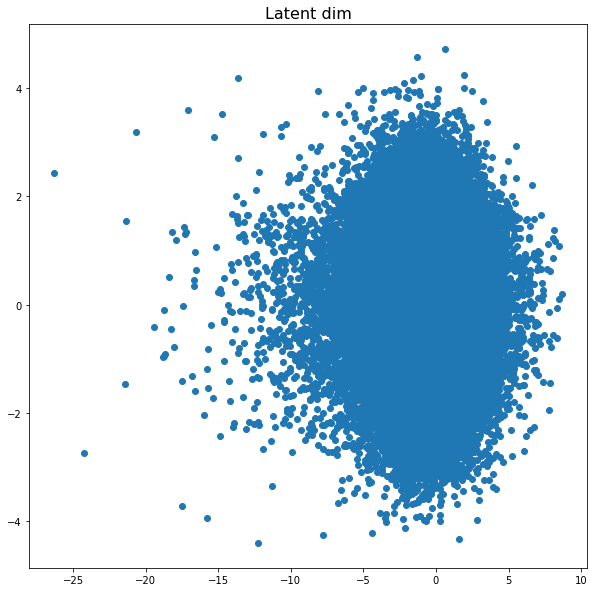

In [20]:
if LATENT_DIM == 2:
    plt.figure(figsize=(10, 10))
    plt.title('Latent dim', size=16)
    plt.scatter(*encs.T)

### Time graph

In [14]:
def init_model():
    np.random.seed(SEED)
    tf.set_random_seed(SEED)

    # example inputs
    inputs = tfkl.Input((OBS_DIM,), dtype=tf.float32, name='inputs')
    latent_inputs = tfkl.Input((LATENT_DIM,), dtype=tf.float32, name='latent_inputs')

    # example encoder (Note: the encoder must output the mean and std for a Gaussian)
    encoder_x = inputs
    for i in range(2):
        encoder_x = tfkl.Dense(256, activation="relu",
                               name="hidden/dense_encoder_{}".format(i))(encoder_x)
    encoder_output_mean = tfkl.Dense(LATENT_DIM, name="encoder_output_mean")(encoder_x)
    encoder_output_std = tfkl.Dense(LATENT_DIM, activation=lambda x: tf.nn.softplus(x) + 1e-4,
                                    name="encoder_output_std")(encoder_x)
    encoder = tf.keras.Model(inputs, [encoder_output_mean, encoder_output_std], name="encoder")

    # example decoder (Note: the decoder must output either the mean for a Gaussian or the logits for a Bernoulli)
    decoder_x = latent_inputs
    for i in range(2):
        decoder_x = tfkl.Dense(256, activation="relu",
                               name="hidden/dense_decoder_{}".format(i))(decoder_x)
    decoder_output = tfkl.Dense(OBS_DIM, name="decoder_output_mean")(decoder_x)
    decoder = tf.keras.Model(latent_inputs, decoder_output, name="decoder")

    # keras model
    vae_model = VAEModel(
        encoder=encoder,
        decoder=decoder,
        likelihood_dist_family=LIKELIHOOD_DIST_FAMILY,
    )
    vae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return vae_model

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss')<1):
            print("\nReached loss < 1!")
            self.model.stop_training = True
            
callback = myCallback()

In [27]:
chunksize = 10 ** 5
times = []
for i in range(0, 30, 2):
    chunk_index = 0
    model = init_model()
    a = datetime.datetime.now()
    for chunk in pd.read_csv(filename, chunksize=chunksize, skiprows=1, header=None, sep=" |\t", error_bad_lines = False):
        X = chunk.iloc[:, 1:]
        del chunk
        X = np.array(X)
        model.fit(X, epochs=EPOCHS, batch_size=BATCH_SIZE)
        if chunk_index == i:
            break
        chunk_index = chunk_index + 1
    b = datetime.datetime.now()
    print("Total Time")
    print(b-a)
    times.append(b - a)

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 5s 50us/sample - loss: 181.1966 - rate: 0.1409 - distortion: 181.0506
Epoch 2/15
100000/100000 [==============================] - 3s 26us/sample - loss: 179.5586 - rate: 0.0468 - distortion: 179.51010s - loss: 179.6407 - rate: 0.0461 - distortion: 179.59 - ETA: 0s - loss: 179.6101 - rate: 0.0462 - distortion: 17
Epoch 3/15
100000/100000 [==============================] - 3s 28us/sample - loss: 178.4696 - rate: 0.0575 - distortion: 178.41082s - loss: 179.0420 - ra
Epoch 4/15
100000/100000 [==============================] - 3s 27us/sample - loss: 177.4750 - rate: 0.0605 - distortion: 177.4113
Epoch 5/15
100000/100000 [==============================] - 3s 32us/sample - loss: 176.4975 - rate: 0.0674 - distortion: 176.4277
Epoch 6/15
100000/100000 [==============================] - 3s 30us/sample - loss: 175.5177 - rate: 0.0716 - distortion: 175.44260s - loss: 175.5930 - rate: 0.0688 - distortio
Epoch 7/15
1

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 5s 50us/sample - loss: 181.2396 - rate: 0.1161 - distortion: 181.1186
Epoch 2/15
100000/100000 [==============================] - 3s 27us/sample - loss: 179.5895 - rate: 0.0465 - distortion: 179.5413
Epoch 3/15
100000/100000 [==============================] - 3s 26us/sample - loss: 178.4778 - rate: 0.0620 - distortion: 178.4146
Epoch 4/15
100000/100000 [==============================] - 3s 26us/sample - loss: 177.4753 - rate: 0.0688 - distortion: 177.4033
Epoch 5/15
100000/100000 [==============================] - 3s 31us/sample - loss: 176.4877 - rate: 0.0736 - distortion: 176.41182s - loss: 176.
Epoch 6/15
100000/100000 [==============================] - 3s 32us/sample - loss: 175.4951 - rate: 0.0954 - distortion: 175.3960
Epoch 7/15
100000/100000 [==============================] - 3s 29us/sample - loss: 174.4701 - rate: 0.1678 - distortion: 174.30071s - loss: 174.6593 - rate:
Epoch 8/15
100000/100000

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 6s 57us/sample - loss: 181.2280 - rate: 0.1391 - distortion: 181.0839
Epoch 2/15
100000/100000 [==============================] - 4s 36us/sample - loss: 179.5612 - rate: 0.0463 - distortion: 179.5132
Epoch 3/15
100000/100000 [==============================] - 4s 40us/sample - loss: 178.4687 - rate: 0.0616 - distortion: 178.4059
Epoch 4/15
100000/100000 [==============================] - 3s 35us/sample - loss: 177.4723 - rate: 0.0665 - distortion: 177.4025
Epoch 5/15
100000/100000 [==============================] - 4s 36us/sample - loss: 176.4891 - rate: 0.0695 - distortion: 176.4172
Epoch 6/15
100000/100000 [==============================] - 4s 36us/sample - loss: 175.5085 - rate: 0.0782 - distortion: 175.4268
Epoch 7/15
100000/100000 [==============================] - 4s 43us/sample - loss: 174.5254 - rate: 0.0966 - distortion: 174.4273
Epoch 8/15
100000/100000 [==============================] - 4s 37u

100000/100000 [==============================] - 3s 31us/sample - loss: 124.7887 - rate: 0.2815 - distortion: 124.50613s - loss: 125.2336 - rate: 0.2876 - d - ETA: 1s - loss: 124.9957 - rate: 0.2843 - dis - ETA: 0s - loss: 124.8184 - rate: 0.2818 - distortion: 124.
Epoch 12/15
100000/100000 [==============================] - 3s 29us/sample - loss: 123.7947 - rate: 0.2857 - distortion: 123.50752s - loss: 124.3951 - rate:  - ETA: 0s - loss: 123.9260 - rate: 0.2856 - distor
Epoch 13/15
100000/100000 [==============================] - 3s 28us/sample - loss: 122.8028 - rate: 0.2888 - distortion: 122.5122
Epoch 14/15
100000/100000 [==============================] - 3s 29us/sample - loss: 121.8125 - rate: 0.2939 - distortion: 121.5179
Epoch 15/15
100000/100000 [==============================] - 3s 31us/sample - loss: 120.8237 - rate: 0.2984 - distortion: 120.52381s - loss: 121.0345 - rate: 0.2927 -
Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 3s 25us/sam

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 5s 49us/sample - loss: 181.1814 - rate: 0.1156 - distortion: 181.0609
Epoch 2/15
100000/100000 [==============================] - 3s 29us/sample - loss: 179.5467 - rate: 0.0446 - distortion: 179.50040s - loss: 179.5862 - rate: 0.0437 - distortion: 179.
Epoch 3/15
100000/100000 [==============================] - 3s 28us/sample - loss: 178.4667 - rate: 0.0604 - distortion: 178.40512s - loss: 179.076
Epoch 4/15
100000/100000 [==============================] - 3s 28us/sample - loss: 177.4696 - rate: 0.0622 - distortion: 177.40430s - loss: 177.5226 - rate: 0.0616 - distortion: 177.461 - ETA: 0s - loss: 177.5139 - rate: 0.0617 - distortion: 177
Epoch 5/15
100000/100000 [==============================] - 3s 27us/sample - loss: 176.4910 - rate: 0.0621 - distortion: 176.42642s - loss: 176.932
Epoch 6/15
100000/100000 [==============================] - 3s 30us/sample - loss: 175.5210 - rate: 0.0601 - distortion: 

100000/100000 [==============================] - 3s 28us/sample - loss: 139.5142 - rate: 0.2762 - distortion: 139.23522s - loss: 139.9347 -
Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 3s 30us/sample - loss: 134.7898 - rate: 0.2516 - distortion: 134.5362
Epoch 2/15
100000/100000 [==============================] - 3s 27us/sample - loss: 133.7794 - rate: 0.2447 - distortion: 133.53221s - loss: 133.9787 - rate: 0.2406 
Epoch 3/15
100000/100000 [==============================] - 3s 29us/sample - loss: 132.7726 - rate: 0.2412 - distortion: 132.5281
Epoch 4/15
100000/100000 [==============================] - 3s 28us/sample - loss: 131.7691 - rate: 0.2449 - distortion: 131.5234
Epoch 5/15
100000/100000 [==============================] - 3s 28us/sample - loss: 130.7676 - rate: 0.2471 - distortion: 130.51890s - loss: 130.8182 - rate: 0.2482 - distortion: 130
Epoch 6/15
100000/100000 [==============================] - 3s 34us/sample - loss: 129.7684 - rate:

100000/100000 [==============================] - 3s 29us/sample - loss: 76.9858 - rate: 0.2040 - distortion: 76.78011s - loss: 77.2505 - rate: 0.2049
Epoch 4/15
100000/100000 [==============================] - 3s 30us/sample - loss: 75.9054 - rate: 0.2099 - distortion: 75.69422s - loss: 76.3129 - rate: 0.2081 - distortion: 76.1 - ETA: 2s - loss: 76.3017 -
Epoch 5/15
100000/100000 [==============================] - 3s 30us/sample - loss: 74.8281 - rate: 0.2125 - distortion: 74.61432s - loss: 75.1711 - rate: 0.2083 - distorti - ETA: 1s - loss: 75.0552 - rate: 0.210
Epoch 6/15
100000/100000 [==============================] - 3s 30us/sample - loss: 73.7520 - rate: 0.2146 - distortion: 73.5362
Epoch 7/15
100000/100000 [==============================] - 3s 34us/sample - loss: 72.6769 - rate: 0.2211 - distortion: 72.45371s - loss: 73.0585 - rat
Epoch 8/15
100000/100000 [==============================] - 3s 29us/sample - loss: 71.6044 - rate: 0.2268 - distortion: 71.3754
Epoch 9/15
100000/1000

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 6s 55us/sample - loss: 181.2571 - rate: 0.1181 - distortion: 181.1342
Epoch 2/15
100000/100000 [==============================] - 3s 29us/sample - loss: 179.5772 - rate: 0.0463 - distortion: 179.5293
Epoch 3/15
100000/100000 [==============================] - 3s 30us/sample - loss: 178.4740 - rate: 0.0588 - distortion: 178.41402s - loss: 179.1740 - rate: 0.0653 - distortion: 179 - ETA: 2s - loss: 179.1060
Epoch 4/15
100000/100000 [==============================] - 3s 30us/sample - loss: 177.4774 - rate: 0.0681 - distortion: 177.4061
Epoch 5/15
100000/100000 [==============================] - 3s 30us/sample - loss: 176.4916 - rate: 0.0721 - distortion: 176.4171
Epoch 6/15
100000/100000 [==============================] - 3s 30us/sample - loss: 175.5074 - rate: 0.0847 - distortion: 175.4191
Epoch 7/15
100000/100000 [==============================] - ETA: 0s - loss: 174.5089 - rate: 0.1290 - distortion: 174

100000/100000 [==============================] - 3s 34us/sample - loss: 128.7701 - rate: 0.2644 - distortion: 128.5043
Epoch 8/15
100000/100000 [==============================] - 3s 28us/sample - loss: 127.7713 - rate: 0.2678 - distortion: 127.5022
Epoch 9/15
100000/100000 [==============================] - 3s 29us/sample - loss: 126.7759 - rate: 0.2723 - distortion: 126.50281s - loss: 126.9903 - rate: 0.2706 - distortion: 126. - ETA: 1s - loss: 126.9522 - rate: 0.2719 - di
Epoch 10/15
100000/100000 [==============================] - 3s 30us/sample - loss: 125.7806 - rate: 0.2795 - distortion: 125.4998
Epoch 11/15
100000/100000 [==============================] - 3s 28us/sample - loss: 124.7867 - rate: 0.2814 - distortion: 124.5043
Epoch 12/15
100000/100000 [==============================] - 4s 35us/sample - loss: 123.7930 - rate: 0.2856 - distortion: 123.5059
Epoch 13/15
100000/100000 [==============================] - 3s 30us/sample - loss: 122.8027 - rate: 0.2890 - distortion: 122.51

100000/100000 [==============================] - 3s 29us/sample - loss: 64.1343 - rate: 0.2601 - distortion: 63.87241s - loss: 64.3226 - rate: 0.2566 - dis
Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 3s 25us/sample - loss: 60.6635 - rate: 0.2083 - distortion: 60.4536
Epoch 2/15
100000/100000 [==============================] - 3s 29us/sample - loss: 59.5630 - rate: 0.1820 - distortion: 59.37942s - loss: 60
Epoch 3/15
100000/100000 [==============================] - 3s 29us/sample - loss: 58.4661 - rate: 0.1817 - distortion: 58.2824
Epoch 4/15
100000/100000 [==============================] - 3s 34us/sample - loss: 57.3719 - rate: 0.1823 - distortion: 57.18721s - loss: 57.7294 - r
Epoch 5/15
100000/100000 [==============================] - 3s 31us/sample - loss: 56.2794 - rate: 0.1907 - distortion: 56.0865
Epoch 6/15
100000/100000 [==============================] - 3s 29us/sample - loss: 55.1875 - rate: 0.1944 - distortion: 54.9919
Epoch 7/15
100000

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 5s 51us/sample - loss: 181.2379 - rate: 0.1303 - distortion: 181.1026
Epoch 2/15
100000/100000 [==============================] - 3s 29us/sample - loss: 179.5526 - rate: 0.0474 - distortion: 179.50351s - loss: 179.9501 - ra
Epoch 3/15
100000/100000 [==============================] - 3s 31us/sample - loss: 178.4688 - rate: 0.0615 - distortion: 178.4060
Epoch 4/15
100000/100000 [==============================] - 3s 29us/sample - loss: 177.4738 - rate: 0.0663 - distortion: 177.4042
Epoch 5/15
100000/100000 [==============================] - 4s 35us/sample - loss: 176.4936 - rate: 0.0703 - distortion: 176.4209
Epoch 6/15
100000/100000 [==============================] - 3s 30us/sample - loss: 175.5196 - rate: 0.0704 - distortion: 175.44560s - loss: 175.5685 - rate: 0.0682 - distortion: 
Epoch 7/15
100000/100000 [==============================] - 3s 29us/sample - loss: 174.5473 - rate: 0.0723 - distortion: 17

100000/100000 [==============================] - 3s 31us/sample - loss: 127.7706 - rate: 0.2661 - distortion: 127.50322s - loss: 128.
Epoch 9/15
100000/100000 [==============================] - 3s 30us/sample - loss: 126.7717 - rate: 0.2706 - distortion: 126.5004
Epoch 10/15
100000/100000 [==============================] - 3s 31us/sample - loss: 125.7798 - rate: 0.2749 - distortion: 125.50362s - loss: 126.1284 - rate: 0.2717 - distortion: 12 - ETA: 2s - loss: 126.0816 - 
Epoch 11/15
100000/100000 [==============================] - 3s 33us/sample - loss: 124.7854 - rate: 0.2845 - distortion: 124.5000
Epoch 12/15
100000/100000 [==============================] - 3s 29us/sample - loss: 123.7925 - rate: 0.2845 - distortion: 123.5064
Epoch 13/15
100000/100000 [==============================] - 3s 29us/sample - loss: 122.7995 - rate: 0.2887 - distortion: 122.5089
Epoch 14/15
100000/100000 [==============================] - 3s 30us/sample - loss: 121.8098 - rate: 0.2925 - distortion: 121.51661

100000/100000 [==============================] - 3s 27us/sample - loss: 60.6621 - rate: 0.2112 - distortion: 60.4493
Epoch 2/15
100000/100000 [==============================] - 3s 31us/sample - loss: 59.5609 - rate: 0.1827 - distortion: 59.37651s - loss: 59.8404 - rate:
Epoch 3/15
100000/100000 [==============================] - 3s 32us/sample - loss: 58.4645 - rate: 0.1858 - distortion: 58.27673s - loss: 
Epoch 4/15
100000/100000 [==============================] - ETA: 0s - loss: 57.3826 - rate: 0.1828 - distortion: 57.199 - 3s 30us/sample - loss: 57.3706 - rate: 0.1832 - distortion: 57.1849
Epoch 5/15
100000/100000 [==============================] - 3s 30us/sample - loss: 56.2774 - rate: 0.1931 - distortion: 56.0821
Epoch 6/15
100000/100000 [==============================] - 3s 29us/sample - loss: 55.1859 - rate: 0.1960 - distortion: 54.9887
Epoch 7/15
100000/100000 [==============================] - 3s 30us/sample - loss: 54.0960 - rate: 0.1961 - distortion: 53.89852s - loss: 54.489

100000/100000 [==============================] - 3s 30us/sample - loss: -2.7741 - rate: 0.1722 - distortion: -2.94862s - loss: -2.35
Epoch 9/15
100000/100000 [==============================] - 3s 29us/sample - loss: -3.8960 - rate: 0.1800 - distortion: -4.0779
Epoch 10/15
100000/100000 [==============================] - 3s 30us/sample - loss: -5.0175 - rate: 0.1831 - distortion: -5.2029
Epoch 11/15
100000/100000 [==============================] - 3s 31us/sample - loss: -6.1372 - rate: 0.1906 - distortion: -6.32942s - loss: -5.7605 - rate: 0.1841 - distortion: -5 - ETA: 2s - loss: -5.7469
Epoch 12/15
100000/100000 [==============================] - 4s 36us/sample - loss: -7.2562 - rate: 0.1967 - distortion: -7.4547
Epoch 13/15
100000/100000 [==============================] - 3s 30us/sample - loss: -8.3733 - rate: 0.2047 - distortion: -8.5807
Epoch 14/15
100000/100000 [==============================] - 3s 30us/sample - loss: -9.4912 - rate: 0.2110 - distortion: -9.70420s - loss: -9.4181 

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - ETA: 0s - loss: 181.3170 - rate: 0.1328 - distortion: 181.1842- ETA: 2s - loss: 181.6057 - rate: 0.1713 - distortion: 181.434 - ETA: 2s - loss: 181.5898 - rate: 0.1684 - disto - 5s 55us/sample - loss: 181.2923 - rate: 0.1309 - distortion: 181.1563
Epoch 2/15
100000/100000 [==============================] - 3s 29us/sample - loss: 179.5935 - rate: 0.0475 - distortion: 179.54420s - loss: 179.6101 - rate: 0.0471 - distortion: 179.56
Epoch 3/15
100000/100000 [==============================] - 3s 31us/sample - loss: 178.4774 - rate: 0.0630 - distortion: 178.4132
Epoch 4/15
100000/100000 [==============================] - 3s 31us/sample - loss: 177.4760 - rate: 0.0688 - distortion: 177.4040
Epoch 5/15
100000/100000 [==============================] - 3s 30us/sample - loss: 176.4891 - rate: 0.0735 - distortion: 176.4132
Epoch 6/15
100000/100000 [==============================] - 4s 35us/sample - loss: 175.5037 -

100000/100000 [==============================] - 3s 30us/sample - loss: 133.7799 - rate: 0.2422 - distortion: 133.5352
Epoch 3/15
100000/100000 [==============================] - 3s 30us/sample - loss: 132.7745 - rate: 0.2426 - distortion: 132.52860s - loss: 132.9412 - rate: 0.2399 - distor
Epoch 4/15
100000/100000 [==============================] - 3s 30us/sample - loss: 131.7713 - rate: 0.2439 - distortion: 131.5267
Epoch 5/15
100000/100000 [==============================] - 3s 35us/sample - loss: 130.7709 - rate: 0.2484 - distortion: 130.5209
Epoch 6/15
100000/100000 [==============================] - 3s 30us/sample - loss: 129.7697 - rate: 0.2520 - distortion: 129.51570s - loss: 129.8912 - rate: 0.2508 - distor
Epoch 7/15
100000/100000 [==============================] - 3s 32us/sample - loss: 128.7713 - rate: 0.2547 - distortion: 128.5151
Epoch 8/15
100000/100000 [==============================] - 3s 30us/sample - loss: 127.7737 - rate: 0.2587 - distortion: 127.5136
Epoch 9/15
1000

100000/100000 [==============================] - 3s 30us/sample - loss: 70.5362 - rate: 0.2308 - distortion: 70.3033
Epoch 10/15
100000/100000 [==============================] - 4s 36us/sample - loss: 69.4647 - rate: 0.2333 - distortion: 69.2286
Epoch 11/15
100000/100000 [==============================] - 3s 30us/sample - loss: 68.3963 - rate: 0.2405 - distortion: 68.1534
Epoch 12/15
100000/100000 [==============================] - 3s 30us/sample - loss: 67.3301 - rate: 0.2486 - distortion: 67.07971s - loss: 67.6220 - rat
Epoch 13/15
100000/100000 [==============================] - 6s 62us/sample - loss: 66.2636 - rate: 0.2520 - distortion: 66.0093
Epoch 14/15
100000/100000 [==============================] - 4s 43us/sample - loss: 65.1981 - rate: 0.2552 - distortion: 64.9412
Epoch 15/15
100000/100000 [==============================] - 3s 31us/sample - loss: 64.1333 - rate: 0.2614 - distortion: 63.87011s - loss: 64.3568 - rate: 0.2569
Train on 100000 samples
Epoch 1/15
100000/100000 [==

100000/100000 [==============================] - 3s 29us/sample - loss: 3.9889 - rate: 0.1508 - distortion: 3.8364
Epoch 3/15
100000/100000 [==============================] - 3s 30us/sample - loss: 2.8588 - rate: 0.1508 - distortion: 2.70602s - loss: 3.3601 - rate: 0.1497 - distortion: 3.2 - ETA: 2s - loss: 3.2988
Epoch 4/15
100000/100000 [==============================] - 3s 30us/sample - loss: 1.7300 - rate: 0.1511 - distortion: 1.5770
Epoch 5/15
100000/100000 [==============================] - 3s 29us/sample - loss: 0.6017 - rate: 0.1559 - distortion: 0.44432s - loss: 1
Epoch 6/15
100000/100000 [==============================] - 4s 36us/sample - loss: -0.5241 - rate: 0.1619 - distortion: -0.68852s - loss: -0.0657 - rate: 0.1549 - distortion: - - ETA: 2s - loss: -0.1471 
Epoch 7/15
100000/100000 [==============================] - 3s 29us/sample - loss: -1.6485 - rate: 0.1659 - distortion: -1.81582s - loss:
Epoch 8/15
100000/100000 [==============================] - 3s 30us/sample - l

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 5s 52us/sample - loss: 181.3602 - rate: 0.1872 - distortion: 181.16782s - loss: 181.6799 - rate: 0.2449 - dist
Epoch 2/15
100000/100000 [==============================] - 3s 31us/sample - loss: 179.5910 - rate: 0.0515 - distortion: 179.5377
Epoch 3/15
100000/100000 [==============================] - 3s 33us/sample - loss: 178.4756 - rate: 0.0621 - distortion: 178.4123
Epoch 4/15
100000/100000 [==============================] - ETA: 0s - loss: 177.4888 - rate: 0.0733 - distortion: 177.4156- ETA: 1s - loss: 177.8060 - rate:  - 3s 31us/sample - loss: 177.4731 - rate: 0.0734 - distortion: 177.3965
Epoch 5/15
100000/100000 [==============================] - 3s 30us/sample - loss: 176.4782 - rate: 0.0870 - distortion: 176.38882s - loss: 176.9315 - rate: 0.0788 - distortion: 17 - ETA: 2s - loss: 176.7932 - ra
Epoch 6/15
100000/100000 [==============================] - 3s 30us/sample - loss: 175.4575 - rate: 0.

100000/100000 [==============================] - 3s 30us/sample - loss: 130.7695 - rate: 0.2526 - distortion: 130.51541s - loss: 130.9166 - rate: 0.2512 - dis
Epoch 6/15
100000/100000 [==============================] - 3s 31us/sample - loss: 129.7694 - rate: 0.2577 - distortion: 129.5096
Epoch 7/15
100000/100000 [==============================] - 3s 35us/sample - loss: 128.7717 - rate: 0.2613 - distortion: 128.5090
Epoch 8/15
100000/100000 [==============================] - 3s 30us/sample - loss: 127.7715 - rate: 0.2623 - distortion: 127.50780s - loss: 127.8025 - rate: 0.2617 - distortion: 127
Epoch 9/15
100000/100000 [==============================] - 3s 30us/sample - loss: 126.7766 - rate: 0.2718 - distortion: 126.5040
Epoch 10/15
100000/100000 [==============================] - 3s 29us/sample - loss: 125.7821 - rate: 0.2759 - distortion: 125.5049
Epoch 11/15
100000/100000 [==============================] - 3s 30us/sample - loss: 124.7874 - rate: 0.2827 - distortion: 124.50380s - los

100000/100000 [==============================] - 3s 31us/sample - loss: 64.1352 - rate: 0.2639 - distortion: 63.8694
Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 3s 27us/sample - loss: 60.6648 - rate: 0.2090 - distortion: 60.4541
Epoch 2/15
100000/100000 [==============================] - 4s 36us/sample - loss: 59.5639 - rate: 0.1853 - distortion: 59.3769
Epoch 3/15
100000/100000 [==============================] - ETA: 0s - loss: 58.4776 - rate: 0.1864 - distortion: 58.291 - 3s 31us/sample - loss: 58.4676 - rate: 0.1865 - distortion: 58.2791
Epoch 4/15
100000/100000 [==============================] - 3s 31us/sample - loss: 57.3723 - rate: 0.1840 - distortion: 57.18590s - loss: 57.5096 - rate: 0.1830 - distort
Epoch 5/15
100000/100000 [==============================] - 3s 30us/sample - loss: 56.2804 - rate: 0.1919 - distortion: 56.0863
Epoch 6/15
100000/100000 [==============================] - 3s 30us/sample - loss: 55.1880 - rate: 0.1954 - distor

Epoch 13/15
100000/100000 [==============================] - 3s 30us/sample - loss: -8.3708 - rate: 0.2074 - distortion: -8.58101s - loss: -8.1086 - rate: 0.2091 -
Epoch 14/15
100000/100000 [==============================] - 3s 30us/sample - loss: -9.4877 - rate: 0.2123 - distortion: -9.7020
Epoch 15/15
100000/100000 [==============================] - 3s 30us/sample - loss: -10.6042 - rate: 0.2178 - distortion: -10.82430s - loss: -10.5279 - rate: 0.2175 - distortion: -
Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 3s 28us/sample - loss: -13.4146 - rate: 0.1784 - distortion: -13.59502s - loss: -12.9062 - rate: 0.196 - ETA: 1s - loss: -13.2158 - rate: 0.1874 - distortion: -13 - ETA: 0s - loss: -13.2626 - rate: 0.1854 - distort
Epoch 2/15
100000/100000 [==============================] - 3s 30us/sample - loss: -14.5567 - rate: 0.1522 - distortion: -14.71161s - loss: -14.1495 - 
Epoch 3/15
100000/100000 [==============================] - 3s 30us/sample 

100000/100000 [==============================] - 3s 31us/sample - loss: -74.0050 - rate: 0.1990 - distortion: -74.20631s - loss: -73.7605 - rate: 0.1981 - di
Epoch 6/15
100000/100000 [==============================] - 3s 30us/sample - loss: -75.1579 - rate: 0.2062 - distortion: -75.3656
Epoch 7/15
100000/100000 [==============================] - 3s 29us/sample - loss: -76.3085 - rate: 0.2151 - distortion: -76.5254
Epoch 8/15
100000/100000 [==============================] - 3s 31us/sample - loss: -77.4582 - rate: 0.2181 - distortion: -77.67842s - loss: -77.0063
Epoch 9/15
100000/100000 [==============================] - 4s 36us/sample - loss: -78.6060 - rate: 0.2271 - distortion: -78.83580s - loss: -78.5593 - rate: 0.2275 - distortion: -78
Epoch 10/15
100000/100000 [==============================] - 3s 30us/sample - loss: -79.7531 - rate: 0.2296 - distortion: -79.9849
Epoch 11/15
100000/100000 [==============================] - 3s 31us/sample - loss: -80.8988 - rate: 0.2420 - distortion

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 5s 54us/sample - loss: 181.2129 - rate: 0.1133 - distortion: 181.0948
Epoch 2/15
100000/100000 [==============================] - 3s 35us/sample - loss: 179.5707 - rate: 0.0447 - distortion: 179.5243
Epoch 3/15
100000/100000 [==============================] - 3s 31us/sample - loss: 178.4690 - rate: 0.0561 - distortion: 178.4118
Epoch 4/15
100000/100000 [==============================] - 3s 31us/sample - loss: 177.4737 - rate: 0.0632 - distortion: 177.4072
Epoch 5/15
100000/100000 [==============================] - 3s 32us/sample - loss: 176.4956 - rate: 0.0630 - distortion: 176.4302
Epoch 6/15
100000/100000 [==============================] - 3s 31us/sample - loss: 175.5204 - rate: 0.0611 - distortion: 175.4558
Epoch 7/15
100000/100000 [==============================] - 4s 36us/sample - loss: 174.5501 - rate: 0.0637 - distortion: 174.4850
Epoch 8/15
100000/100000 [==============================] - 3s 33u

100000/100000 [==============================] - 3s 31us/sample - loss: 126.7726 - rate: 0.2695 - distortion: 126.5024
Epoch 10/15
100000/100000 [==============================] - 3s 32us/sample - loss: 125.7790 - rate: 0.2752 - distortion: 125.5024
Epoch 11/15
100000/100000 [==============================] - 3s 35us/sample - loss: 124.7842 - rate: 0.2806 - distortion: 124.5026
Epoch 12/15
100000/100000 [==============================] - 3s 32us/sample - loss: 123.7907 - rate: 0.2844 - distortion: 123.5048
Epoch 13/15
100000/100000 [==============================] - 3s 31us/sample - loss: 122.7993 - rate: 0.2885 - distortion: 122.5089
Epoch 14/15
100000/100000 [==============================] - 3s 31us/sample - loss: 121.8094 - rate: 0.2932 - distortion: 121.5156
Epoch 15/15
100000/100000 [==============================] - 4s 35us/sample - loss: 120.8176 - rate: 0.3010 - distortion: 120.5151
Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 3s 28us/sam

100000/100000 [==============================] - 4s 36us/sample - loss: 55.1834 - rate: 0.1983 - distortion: 54.9839
Epoch 7/15
100000/100000 [==============================] - 3s 31us/sample - loss: 54.0938 - rate: 0.2009 - distortion: 53.8916
Epoch 8/15
100000/100000 [==============================] - 3s 30us/sample - loss: 53.0064 - rate: 0.2056 - distortion: 52.79840s - loss: 53.0908 - rate: 0.2058 - distortion
Epoch 9/15
100000/100000 [==============================] - 3s 31us/sample - loss: 51.9187 - rate: 0.2117 - distortion: 51.7053
Epoch 10/15
100000/100000 [==============================] - 3s 32us/sample - loss: 50.8327 - rate: 0.2119 - distortion: 50.6187
Epoch 11/15
100000/100000 [==============================] - 4s 40us/sample - loss: 49.7477 - rate: 0.2204 - distortion: 49.5260
Epoch 12/15
100000/100000 [==============================] - 3s 31us/sample - loss: 48.6646 - rate: 0.2291 - distortion: 48.4328
Epoch 13/15
100000/100000 [==============================] - 3s 31

100000/100000 [==============================] - 3s 30us/sample - loss: -14.5618 - rate: 0.1556 - distortion: -14.72011s - loss: -14.2059 - rate:
Epoch 3/15
100000/100000 [==============================] - 3s 31us/sample - loss: -15.7003 - rate: 0.1534 - distortion: -15.85611s - loss: -15.2875 - ra
Epoch 4/15
100000/100000 [==============================] - 3s 31us/sample - loss: -16.8376 - rate: 0.1549 - distortion: -16.99421s - loss: -16.4810 - rate: 0
Epoch 5/15
100000/100000 [==============================] - 3s 30us/sample - loss: -17.9725 - rate: 0.1617 - distortion: -18.1362
Epoch 6/15
100000/100000 [==============================] - 4s 36us/sample - loss: -19.1080 - rate: 0.1661 - distortion: -19.2766
Epoch 7/15
100000/100000 [==============================] - 3s 30us/sample - loss: -20.2400 - rate: 0.1707 - distortion: -20.4122
Epoch 8/15
100000/100000 [==============================] - ETA: 0s - loss: -21.3610 - rate: 0.1783 - distortion: -21.539 - 3s 31us/sample - loss: -21.

100000/100000 [==============================] - 3s 31us/sample - loss: -83.1898 - rate: 0.2570 - distortion: -83.4479
Epoch 14/15
100000/100000 [==============================] - 3s 30us/sample - loss: -84.3327 - rate: 0.2646 - distortion: -84.5995
Epoch 15/15
100000/100000 [==============================] - 4s 37us/sample - loss: -85.4721 - rate: 0.2705 - distortion: -85.7450
Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 3s 28us/sample - loss: -88.1603 - rate: 0.2302 - distortion: -88.3924
Epoch 2/15
100000/100000 [==============================] - 3s 33us/sample - loss: -89.3249 - rate: 0.2117 - distortion: -89.5386
Epoch 3/15
100000/100000 [==============================] - 3s 30us/sample - loss: -90.4851 - rate: 0.2160 - distortion: -90.7027
Epoch 4/15
100000/100000 [==============================] - 3s 31us/sample - loss: -91.6446 - rate: 0.2196 - distortion: -91.8647
Epoch 5/15
100000/100000 [==============================] - 3s 31us/sample 

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 6s 58us/sample - loss: 181.1670 - rate: 0.1404 - distortion: 181.021710s - loss: 181.8763 - rate: 0.2586 - distortion:  - ETA: 5s - loss: 181.7110 - rate: 
Epoch 2/15
100000/100000 [==============================] - 3s 29us/sample - loss: 179.5423 - rate: 0.0570 - distortion: 179.48351s - loss: 179.9582 - rate: 0.0529 - distortion: 179.905 - ETA: 1s - loss: 179.9608 - rate: 0.0533 - distortion: 17 - ETA: 1s - loss: 179.8447 - rate: 0.053 - ETA: 0s - loss: 179.5507 - rate: 0.0568 - distortion: 179.493
Epoch 3/15
100000/100000 [==============================] - 3s 32us/sample - loss: 178.4596 - rate: 0.0742 - distortion: 178.38421s - loss: 178.6546 - rate: 0.0707 - dist
Epoch 4/15
100000/100000 [==============================] - 3s 32us/sample - loss: 177.4437 - rate: 0.1018 - distortion: 177.3387
Epoch 5/15
100000/100000 [==============================] - 4s 35us/sample - loss: 176.4155 - rate: 0.1672 - 

100000/100000 [==============================] - 3s 33us/sample - loss: 128.7788 - rate: 0.2631 - distortion: 128.5143
Epoch 8/15
100000/100000 [==============================] - 3s 35us/sample - loss: 127.7800 - rate: 0.2652 - distortion: 127.51352s - loss: 128.
Epoch 9/15
100000/100000 [==============================] - 3s 30us/sample - loss: 126.7837 - rate: 0.2676 - distortion: 126.5154
Epoch 10/15
100000/100000 [==============================] - 3s 31us/sample - loss: 125.7891 - rate: 0.2747 - distortion: 125.51302s - loss: 126.1167 - r
Epoch 11/15
100000/100000 [==============================] - 3s 32us/sample - loss: 124.7958 - rate: 0.2798 - distortion: 124.5150
Epoch 12/15
100000/100000 [==============================] - 3s 31us/sample - loss: 123.8018 - rate: 0.2836 - distortion: 123.5166
Epoch 13/15
100000/100000 [==============================] - 4s 36us/sample - loss: 122.8106 - rate: 0.2918 - distortion: 122.5170
Epoch 14/15
100000/100000 [==============================] 

100000/100000 [==============================] - 3s 30us/sample - loss: 57.3807 - rate: 0.1857 - distortion: 57.1925
Epoch 5/15
100000/100000 [==============================] - 3s 31us/sample - loss: 56.2882 - rate: 0.1882 - distortion: 56.0978
Epoch 6/15
100000/100000 [==============================] - 3s 31us/sample - loss: 55.1966 - rate: 0.1930 - distortion: 55.00240s - loss: 55.3488 - rate: 0.1932 - dist
Epoch 7/15
100000/100000 [==============================] - 3s 33us/sample - loss: 54.1067 - rate: 0.1983 - distortion: 53.90711s - loss: 54.4141 - rate: 
Epoch 8/15
100000/100000 [==============================] - 3s 34us/sample - loss: 53.0189 - rate: 0.2032 - distortion: 52.8134
Epoch 9/15
100000/100000 [==============================] - 3s 31us/sample - loss: 51.9318 - rate: 0.2112 - distortion: 51.7188
Epoch 10/15
100000/100000 [==============================] - 3s 32us/sample - loss: 50.8458 - rate: 0.2135 - distortion: 50.6303
Epoch 11/15
100000/100000 [====================

100000/100000 [==============================] - 3s 28us/sample - loss: -13.4060 - rate: 0.1771 - distortion: -13.58511s - loss: -13.1053 - rate: 0.1934 - distortion: -13. - ETA: 1s - loss: -13.1471 - rate: 0.1893  - ETA: 0s - loss: -13.3963 - rate: 0.1775 - distortion: -13.573
Epoch 2/15
100000/100000 [==============================] - 3s 34us/sample - loss: -14.5482 - rate: 0.1560 - distortion: -14.7069
Epoch 3/15
100000/100000 [==============================] - 3s 31us/sample - loss: -15.6873 - rate: 0.1543 - distortion: -15.8440
Epoch 4/15
100000/100000 [==============================] - 3s 31us/sample - loss: -16.8242 - rate: 0.1557 - distortion: -16.9816
Epoch 5/15
100000/100000 [==============================] - 3s 31us/sample - loss: -17.9600 - rate: 0.1577 - distortion: -18.1198
Epoch 6/15
100000/100000 [==============================] - 3s 31us/sample - loss: -19.0940 - rate: 0.1657 - distortion: -19.26231s - loss: -18.7401 - rate: 0.1621 - ETA: 0s - loss: -19.0481 - rate: 0.

100000/100000 [==============================] - 3s 32us/sample - loss: -77.4495 - rate: 0.2160 - distortion: -77.66771s - loss: -77.1205 - rate: 
Epoch 9/15
100000/100000 [==============================] - 3s 31us/sample - loss: -78.5976 - rate: 0.2258 - distortion: -78.82611s - loss: -78.3141 - rate: 0.22
Epoch 10/15
100000/100000 [==============================] - ETA: 0s - loss: -79.7337 - rate: 0.2337 - distortion: -79.967 - 4s 38us/sample - loss: -79.7447 - rate: 0.2342 - distortion: -79.9810
Epoch 11/15
100000/100000 [==============================] - 3s 32us/sample - loss: -80.8899 - rate: 0.2424 - distortion: -81.1349
Epoch 12/15
100000/100000 [==============================] - 3s 31us/sample - loss: -82.0343 - rate: 0.2470 - distortion: -82.2824
Epoch 13/15
100000/100000 [==============================] - 3s 31us/sample - loss: -83.1768 - rate: 0.2582 - distortion: -83.43601s - loss: -82.9488 - rate: 0.2576 - d
Epoch 14/15
100000/100000 [==============================] - 3s 3

100000/100000 [==============================] - 3s 31us/sample - loss: -145.4023 - rate: 0.2868 - distortion: -145.69162s - loss: -144.9260 
Epoch 3/15
100000/100000 [==============================] - 3s 31us/sample - loss: -146.5616 - rate: 0.2868 - distortion: -146.8500
Epoch 4/15
100000/100000 [==============================] - 4s 37us/sample - loss: -147.7178 - rate: 0.2970 - distortion: -148.0157
Epoch 5/15
100000/100000 [==============================] - 3s 31us/sample - loss: -148.8732 - rate: 0.3007 - distortion: -149.1760
Epoch 6/15
100000/100000 [==============================] - 3s 31us/sample - loss: -150.0263 - rate: 0.3090 - distortion: -150.3382
Epoch 7/15
100000/100000 [==============================] - 3s 31us/sample - loss: -151.1768 - rate: 0.3132 - distortion: -151.4925
Epoch 8/15
100000/100000 [==============================] - 3s 30us/sample - loss: -152.3274 - rate: 0.3203 - distortion: -152.6493
Epoch 9/15
100000/100000 [==============================] - 4s 36u

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 6s 62us/sample - loss: 181.2129 - rate: 0.1331 - distortion: 181.07494s - loss: 181.6520 - rate: 0.196
Epoch 2/15
100000/100000 [==============================] - 3s 31us/sample - loss: 179.5560 - rate: 0.0526 - distortion: 179.50172s - loss: 1
Epoch 3/15
100000/100000 [==============================] - 3s 32us/sample - loss: 178.4745 - rate: 0.0657 - distortion: 178.4076
Epoch 4/15
100000/100000 [==============================] - 3s 32us/sample - loss: 177.4780 - rate: 0.0690 - distortion: 177.4058
Epoch 5/15
100000/100000 [==============================] - ETA: 0s - loss: 176.5074 - rate: 0.0748 - distortion: 176.432 - 3s 32us/sample - loss: 176.4957 - rate: 0.0749 - distortion: 176.4185
Epoch 6/15
100000/100000 [==============================] - 4s 37us/sample - loss: 175.5061 - rate: 0.0918 - distortion: 175.4108
Epoch 7/15
100000/100000 [==============================] - 3s 32us/sample - loss: 174.

100000/100000 [==============================] - 3s 32us/sample - loss: 131.7755 - rate: 0.2478 - distortion: 131.52702s - loss: 13
Epoch 5/15
100000/100000 [==============================] - 3s 31us/sample - loss: 130.7717 - rate: 0.2487 - distortion: 130.52152s - loss: 131.1
Epoch 6/15
100000/100000 [==============================] - 3s 31us/sample - loss: 129.7714 - rate: 0.2531 - distortion: 129.5162
Epoch 7/15
100000/100000 [==============================] - 4s 36us/sample - loss: 128.7727 - rate: 0.2583 - distortion: 128.5130
Epoch 8/15
100000/100000 [==============================] - 3s 31us/sample - loss: 127.7745 - rate: 0.2594 - distortion: 127.5138
Epoch 9/15
100000/100000 [==============================] - 3s 32us/sample - loss: 126.7796 - rate: 0.2642 - distortion: 126.5146
Epoch 10/15
100000/100000 [==============================] - 3s 31us/sample - loss: 125.7839 - rate: 0.2720 - distortion: 125.5105
Epoch 11/15
100000/100000 [==============================] - 3s 31us/sa

100000/100000 [==============================] - 3s 28us/sample - loss: 60.6648 - rate: 0.2099 - distortion: 60.45332s - loss: 61.1307 - rate: 0.2318 - dist - ETA: 1s - loss: 60.9694 - rate: 0.2240 - distortion: 60.745 - ETA: 1s - loss: 60.9594 - rate: 0.2235
Epoch 2/15
100000/100000 [==============================] - 3s 31us/sample - loss: 59.5651 - rate: 0.1846 - distortion: 59.3789
Epoch 3/15
100000/100000 [==============================] - 3s 31us/sample - loss: 58.4677 - rate: 0.1820 - distortion: 58.2838
Epoch 4/15
100000/100000 [==============================] - 3s 32us/sample - loss: 57.3734 - rate: 0.1808 - distortion: 57.1901
Epoch 5/15
100000/100000 [==============================] - 3s 34us/sample - loss: 56.2804 - rate: 0.1922 - distortion: 56.0861
Epoch 6/15
100000/100000 [==============================] - 3s 31us/sample - loss: 55.1890 - rate: 0.1948 - distortion: 54.9931
Epoch 7/15
100000/100000 [==============================] - 3s 31us/sample - loss: 54.1002 - rate: 0

100000/100000 [==============================] - 3s 32us/sample - loss: -9.4877 - rate: 0.2111 - distortion: -9.7008
Epoch 15/15
100000/100000 [==============================] - 3s 31us/sample - loss: -10.6026 - rate: 0.2166 - distortion: -10.8215
Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 3s 30us/sample - loss: -13.4147 - rate: 0.1749 - distortion: -13.59161s - loss: -13.0949 - rate: 0.1882 - distorti - ETA: 1s - loss: -13.2293 - rate: 0.1822 - dis
Epoch 2/15
100000/100000 [==============================] - 4s 37us/sample - loss: -14.5561 - rate: 0.1566 - distortion: -14.7154
Epoch 3/15
100000/100000 [==============================] - 3s 30us/sample - loss: -15.6953 - rate: 0.1552 - distortion: -15.8530
Epoch 4/15
100000/100000 [==============================] - 3s 31us/sample - loss: -16.8324 - rate: 0.1539 - distortion: -16.9880
Epoch 5/15
100000/100000 [==============================] - 3s 31us/sample - loss: -17.9681 - rate: 0.1596 - distor

100000/100000 [==============================] - 4s 38us/sample - loss: -78.6062 - rate: 0.2271 - distortion: -78.83603s - loss: -78
Epoch 10/15
100000/100000 [==============================] - 3s 32us/sample - loss: -79.7531 - rate: 0.2347 - distortion: -79.9900
Epoch 11/15
100000/100000 [==============================] - 3s 32us/sample - loss: -80.8983 - rate: 0.2414 - distortion: -81.1422
Epoch 12/15
100000/100000 [==============================] - 3s 31us/sample - loss: -82.0425 - rate: 0.2429 - distortion: -82.2866
Epoch 13/15
100000/100000 [==============================] - 3s 34us/sample - loss: -83.1843 - rate: 0.2569 - distortion: -83.4422
Epoch 14/15
100000/100000 [==============================] - 4s 35us/sample - loss: -84.3269 - rate: 0.2612 - distortion: -84.59040s - loss: -84.2579 - rate: 0.2606 - distortion: -8
Epoch 15/15
100000/100000 [==============================] - 3s 32us/sample - loss: -85.4667 - rate: 0.2666 - distortion: -85.7357
Train on 100000 samples
Epoch 

100000/100000 [==============================] - 3s 33us/sample - loss: -151.1853 - rate: 0.3094 - distortion: -151.4971
Epoch 8/15
100000/100000 [==============================] - 3s 31us/sample - loss: -152.3343 - rate: 0.3192 - distortion: -152.65502s - loss: -151.909
Epoch 9/15
100000/100000 [==============================] - 3s 31us/sample - loss: -153.4824 - rate: 0.3309 - distortion: -153.8147
Epoch 10/15
100000/100000 [==============================] - 4s 37us/sample - loss: -154.6278 - rate: 0.3334 - distortion: -154.9636
Epoch 11/15
100000/100000 [==============================] - 3s 32us/sample - loss: -155.7724 - rate: 0.3430 - distortion: -156.1168
Epoch 12/15
100000/100000 [==============================] - 3s 32us/sample - loss: -156.9143 - rate: 0.3502 - distortion: -157.2657
Epoch 13/15
100000/100000 [==============================] - 3s 31us/sample - loss: -158.0556 - rate: 0.3592 - distortion: -158.4177
Epoch 14/15
100000/100000 [==============================] - 3s 

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 6s 58us/sample - loss: 181.1936 - rate: 0.1133 - distortion: 181.0754 34s - loss: 182.2629 - rate: 0.1914 -  - ETA: 8s - loss: 181.8365 - rate: 0.1 - ETA: 0s - loss: 181.3278 - rate: 0.1244 - distortion: 1
Epoch 2/15
100000/100000 [==============================] - 3s 30us/sample - loss: 179.5448 - rate: 0.0516 - distortion: 179.49150s - loss: 179.6785 - rate: 0.0499 - distortio
Epoch 3/15
100000/100000 [==============================] - 3s 32us/sample - loss: 178.4620 - rate: 0.0762 - distortion: 178.3845
Epoch 4/15
100000/100000 [==============================] - 4s 38us/sample - loss: 177.4536 - rate: 0.0930 - distortion: 177.3574
Epoch 5/15
100000/100000 [==============================] - 3s 33us/sample - loss: 176.4289 - rate: 0.1488 - distortion: 176.2776
Epoch 6/15
100000/100000 [==============================] - 3s 34us/sample - loss: 175.4130 - rate: 0.1912 - distortion: 175.2183
Epoch 7/15
100

100000/100000 [==============================] - 3s 33us/sample - loss: 127.7779 - rate: 0.2710 - distortion: 127.5055
Epoch 9/15
100000/100000 [==============================] - 3s 34us/sample - loss: 126.7790 - rate: 0.2735 - distortion: 126.5047
Epoch 10/15
100000/100000 [==============================] - 4s 37us/sample - loss: 125.7854 - rate: 0.2781 - distortion: 125.5060
Epoch 11/15
100000/100000 [==============================] - 3s 32us/sample - loss: 124.7915 - rate: 0.2846 - distortion: 124.5060
Epoch 12/15
100000/100000 [==============================] - 3s 32us/sample - loss: 123.7995 - rate: 0.2874 - distortion: 123.5105
Epoch 13/15
100000/100000 [==============================] - 3s 32us/sample - loss: 122.8060 - rate: 0.2900 - distortion: 122.5142
Epoch 14/15
100000/100000 [==============================] - 4s 38us/sample - loss: 121.8157 - rate: 0.2949 - distortion: 121.52011s - loss: 122.0604 - rate: 0.3003
Epoch 15/15
100000/100000 [==============================] - 3

100000/100000 [==============================] - 3s 32us/sample - loss: 55.1937 - rate: 0.1979 - distortion: 54.99471s - loss: 55.4424 - rate: 0.202
Epoch 7/15
100000/100000 [==============================] - 3s 31us/sample - loss: 54.1052 - rate: 0.1990 - distortion: 53.9049
Epoch 8/15
100000/100000 [==============================] - 3s 33us/sample - loss: 53.0161 - rate: 0.2051 - distortion: 52.8087
Epoch 9/15
100000/100000 [==============================] - 4s 37us/sample - loss: 51.9287 - rate: 0.2107 - distortion: 51.71632s - loss: 52.2139 - rate: 0.2
Epoch 10/15
100000/100000 [==============================] - 3s 32us/sample - loss: 50.8439 - rate: 0.2163 - distortion: 50.62552s - loss: 51.32
Epoch 11/15
100000/100000 [==============================] - 3s 35us/sample - loss: 49.7584 - rate: 0.2205 - distortion: 49.5366
Epoch 12/15
100000/100000 [==============================] - 3s 32us/sample - loss: 48.6752 - rate: 0.2268 - distortion: 48.4457
Epoch 13/15
100000/100000 [=======

100000/100000 [==============================] - 3s 33us/sample - loss: -15.6899 - rate: 0.1493 - distortion: -15.8416
Epoch 4/15
100000/100000 [==============================] - 3s 34us/sample - loss: -16.8263 - rate: 0.1556 - distortion: -16.9836
Epoch 5/15
100000/100000 [==============================] - 4s 37us/sample - loss: -17.9627 - rate: 0.1597 - distortion: -18.1244
Epoch 6/15
100000/100000 [==============================] - 3s 33us/sample - loss: -19.0968 - rate: 0.1666 - distortion: -19.2658
Epoch 7/15
100000/100000 [==============================] - 3s 33us/sample - loss: -20.2295 - rate: 0.1723 - distortion: -20.4033
Epoch 8/15
100000/100000 [==============================] - 3s 32us/sample - loss: -21.3607 - rate: 0.1762 - distortion: -21.53921s - loss: -21.1110 - rate: 0.1750 -
Epoch 9/15
100000/100000 [==============================] - 4s 39us/sample - loss: -22.4916 - rate: 0.1807 - distortion: -22.6743
Epoch 10/15
100000/100000 [==============================] - 3s 3

100000/100000 [==============================] - 3s 33us/sample - loss: -85.4627 - rate: 0.2729 - distortion: -85.7379
Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 3s 29us/sample - loss: -88.1499 - rate: 0.2294 - distortion: -88.38112s - loss: -87.7948 -  - ETA: 0s - loss: -88.1287 - rate: 0.2303 - distortion: -88.35
Epoch 2/15
100000/100000 [==============================] - 3s 32us/sample - loss: -89.3147 - rate: 0.2131 - distortion: -89.5298
Epoch 3/15
100000/100000 [==============================] - 3s 32us/sample - loss: -90.4766 - rate: 0.2145 - distortion: -90.6926
Epoch 4/15
100000/100000 [==============================] - 3s 33us/sample - loss: -91.6347 - rate: 0.2185 - distortion: -91.85380s - loss: -91.4799 - rate: 0.2152 - disto
Epoch 5/15
100000/100000 [==============================] - 4s 37us/sample - loss: -92.7922 - rate: 0.2278 - distortion: -93.0216
Epoch 6/15
100000/100000 [==============================] - 3s 32us/sample - los

100000/100000 [==============================] - 3s 33us/sample - loss: -153.4777 - rate: 0.3275 - distortion: -153.8065
Epoch 10/15
100000/100000 [==============================] - 4s 35us/sample - loss: -154.6230 - rate: 0.3330 - distortion: -154.9583
Epoch 11/15
100000/100000 [==============================] - 3s 32us/sample - loss: -155.7681 - rate: 0.3413 - distortion: -156.1108
Epoch 12/15
100000/100000 [==============================] - 3s 32us/sample - loss: -156.9096 - rate: 0.3500 - distortion: -157.26081s - loss: -156.5824 - rate: 0.34
Epoch 13/15
100000/100000 [==============================] - 3s 32us/sample - loss: -158.0509 - rate: 0.3601 - distortion: -158.4139
Epoch 14/15
100000/100000 [==============================] - 4s 38us/sample - loss: -159.1894 - rate: 0.3640 - distortion: -159.5551
Epoch 15/15
100000/100000 [==============================] - 3s 33us/sample - loss: -160.3274 - rate: 0.3738 - distortion: -160.7029
Train on 100000 samples
Epoch 1/15
100000/100000

100000/100000 [==============================] - 3s 32us/sample - loss: -225.8923 - rate: 0.5093 - distortion: -226.4023
Epoch 7/15
100000/100000 [==============================] - 3s 33us/sample - loss: -227.0358 - rate: 0.5238 - distortion: -227.5600
Epoch 8/15
100000/100000 [==============================] - 3s 33us/sample - loss: -228.1765 - rate: 0.5269 - distortion: -228.7045
Epoch 9/15
100000/100000 [==============================] - 3s 32us/sample - loss: -229.3143 - rate: 0.5343 - distortion: -229.8505
Epoch 10/15
100000/100000 [==============================] - 4s 39us/sample - loss: -230.4489 - rate: 0.5440 - distortion: -230.9931
Epoch 11/15
100000/100000 [==============================] - 3s 32us/sample - loss: -231.5821 - rate: 0.5527 - distortion: -232.13602s - loss: -231.2447 - rate: 0.5416 - distortion - ETA: 2s - loss: -231.2434 - rat
Epoch 12/15
100000/100000 [==============================] - 3s 32us/sample - loss: -232.7113 - rate: 0.5626 - distortion: -233.2768
Ep

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 6s 64us/sample - loss: 181.2109 - rate: 0.1114 - distortion: 181.0946
Epoch 2/15
100000/100000 [==============================] - 3s 30us/sample - loss: 179.5658 - rate: 0.0446 - distortion: 179.51951s - loss: 179.9886 - rate: 0 - ETA: 0s - loss: 179.5965 - rate: 0.0445 - distortion: 179.55 - ETA: 0s - loss: 179.5741 - rate: 0.0444 - distortion: 179.529
Epoch 3/15
100000/100000 [==============================] - 3s 33us/sample - loss: 178.4735 - rate: 0.0591 - distortion: 178.4132
Epoch 4/15
100000/100000 [==============================] - 3s 33us/sample - loss: 177.4766 - rate: 0.0629 - distortion: 177.4106
Epoch 5/15
100000/100000 [==============================] - 3s 34us/sample - loss: 176.4986 - rate: 0.0624 - distortion: 176.4338
Epoch 6/15
100000/100000 [==============================] - 4s 37us/sample - loss: 175.5251 - rate: 0.0579 - distortion: 175.4637
Epoch 7/15
100000/100000 [==============

100000/100000 [==============================] - 3s 33us/sample - loss: 126.7783 - rate: 0.2475 - distortion: 126.5301
Epoch 10/15
100000/100000 [==============================] - 4s 39us/sample - loss: 125.7849 - rate: 0.2562 - distortion: 125.5273
Epoch 11/15
100000/100000 [==============================] - 3s 33us/sample - loss: 124.7896 - rate: 0.2623 - distortion: 124.5264
Epoch 12/15
100000/100000 [==============================] - 3s 34us/sample - loss: 123.7982 - rate: 0.2682 - distortion: 123.52840s - loss: 123.8644 - rate: 0.2689 - distortion: 12
Epoch 13/15
100000/100000 [==============================] - 3s 33us/sample - loss: 122.8054 - rate: 0.2719 - distortion: 122.5317
Epoch 14/15
100000/100000 [==============================] - 4s 36us/sample - loss: 121.8155 - rate: 0.2789 - distortion: 121.5359
Epoch 15/15
100000/100000 [==============================] - 4s 39us/sample - loss: 120.8249 - rate: 0.2861 - distortion: 120.53733s - loss: 121.2275 -
Train on 100000 samples

100000/100000 [==============================] - 5s 49us/sample - loss: 56.2738 - rate: 0.1888 - distortion: 56.08281s - loss: 56.4277 - rate: 0.1869 - disto
Epoch 6/15
100000/100000 [==============================] - 3s 33us/sample - loss: 55.1825 - rate: 0.1948 - distortion: 54.9866
Epoch 7/15
100000/100000 [==============================] - 3s 34us/sample - loss: 54.0929 - rate: 0.1964 - distortion: 53.8951
Epoch 8/15
100000/100000 [==============================] - 4s 35us/sample - loss: 53.0047 - rate: 0.2038 - distortion: 52.7985
Epoch 9/15
100000/100000 [==============================] - 4s 39us/sample - loss: 51.9165 - rate: 0.2107 - distortion: 51.70422s - loss: 52.2837 - 
Epoch 10/15
100000/100000 [==============================] - 3s 33us/sample - loss: 50.8312 - rate: 0.2115 - distortion: 50.6176
Epoch 11/15
100000/100000 [==============================] - 3s 33us/sample - loss: 49.7472 - rate: 0.2173 - distortion: 49.5285
Epoch 12/15
100000/100000 [========================

100000/100000 [==============================] - 3s 32us/sample - loss: -14.5641 - rate: 0.1568 - distortion: -14.72362s - loss: -14.1961 - rate:
Epoch 3/15
100000/100000 [==============================] - 3s 33us/sample - loss: -15.7022 - rate: 0.1515 - distortion: -15.8561
Epoch 4/15
100000/100000 [==============================] - 4s 38us/sample - loss: -16.8395 - rate: 0.1533 - distortion: -16.99452s - loss: -16.3873 -
Epoch 5/15
100000/100000 [==============================] - 3s 32us/sample - loss: -17.9748 - rate: 0.1592 - distortion: -18.1360
Epoch 6/15
100000/100000 [==============================] - 3s 34us/sample - loss: -19.1097 - rate: 0.1663 - distortion: -19.2786
Epoch 7/15
100000/100000 [==============================] - 3s 33us/sample - loss: -20.2423 - rate: 0.1730 - distortion: -20.4168
Epoch 8/15
100000/100000 [==============================] - 3s 32us/sample - loss: -21.3735 - rate: 0.1755 - distortion: -21.5512
Epoch 9/15
100000/100000 [===========================

100000/100000 [==============================] - 3s 33us/sample - loss: -84.3341 - rate: 0.2652 - distortion: -84.6015
Epoch 15/15
100000/100000 [==============================] - 3s 33us/sample - loss: -85.4743 - rate: 0.2715 - distortion: -85.7482
Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 3s 29us/sample - loss: -88.1627 - rate: 0.2291 - distortion: -88.39361s - loss: -87.8401 - rate: 0.
Epoch 2/15
100000/100000 [==============================] - 3s 32us/sample - loss: -89.3274 - rate: 0.2098 - distortion: -89.5391
Epoch 3/15
100000/100000 [==============================] - 3s 32us/sample - loss: -90.4882 - rate: 0.2142 - distortion: -90.7040
Epoch 4/15
100000/100000 [==============================] - 4s 39us/sample - loss: -91.6467 - rate: 0.2187 - distortion: -91.8660
Epoch 5/15
100000/100000 [==============================] - 3s 33us/sample - loss: -92.8045 - rate: 0.2232 - distortion: -93.0291
Epoch 6/15
100000/100000 [====================

100000/100000 [==============================] - 4s 38us/sample - loss: -153.4894 - rate: 0.3303 - distortion: -153.82112s - loss: -153.0690 - rate: 0 - ETA: 0s - loss: -153.3784 - rate: 0.3299 - distortion: -153.70 - ETA: 0s - loss: -153.4099 - rate: 0.3293 - distortion: -1
Epoch 10/15
100000/100000 [==============================] - 3s 33us/sample - loss: -154.6367 - rate: 0.3367 - distortion: -154.9757
Epoch 11/15
100000/100000 [==============================] - 3s 32us/sample - loss: -155.7797 - rate: 0.3401 - distortion: -156.1212
Epoch 12/15
100000/100000 [==============================] - 4s 37us/sample - loss: -156.9224 - rate: 0.3491 - distortion: -157.2727
Epoch 13/15
100000/100000 [==============================] - 4s 39us/sample - loss: -158.0629 - rate: 0.3554 - distortion: -158.4213
Epoch 14/15
100000/100000 [==============================] - 3s 33us/sample - loss: -159.2030 - rate: 0.3660 - distortion: -159.5706
Epoch 15/15
100000/100000 [==============================] 

100000/100000 [==============================] - 4s 37us/sample - loss: -223.6102 - rate: 0.4947 - distortion: -224.10841s - loss: -223.3817 - rate: 0.4922 -
Epoch 5/15
100000/100000 [==============================] - 3s 34us/sample - loss: -224.7606 - rate: 0.5031 - distortion: -225.2665
Epoch 6/15
100000/100000 [==============================] - 3s 33us/sample - loss: -225.9055 - rate: 0.5135 - distortion: -226.4198
Epoch 7/15
100000/100000 [==============================] - 3s 34us/sample - loss: -227.0483 - rate: 0.5179 - distortion: -227.5667
Epoch 8/15
100000/100000 [==============================] - 4s 39us/sample - loss: -228.1901 - rate: 0.5218 - distortion: -228.71300s - loss: -228.0518 - rate: 0.5202 - distortio
Epoch 9/15
100000/100000 [==============================] - 3s 34us/sample - loss: -229.3255 - rate: 0.5353 - distortion: -229.8627
Epoch 10/15
100000/100000 [==============================] - 3s 34us/sample - loss: -230.4623 - rate: 0.5423 - distortion: -231.00501s 

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 6s 62us/sample - loss: 181.1312 - rate: 0.1008 - distortion: 181.02567s - loss: 181.6543 - rat
Epoch 2/15
100000/100000 [==============================] - 3s 31us/sample - loss: 179.5381 - rate: 0.0479 - distortion: 179.48851s - loss: 179.8026 - rate: 0.0457 -
Epoch 3/15
100000/100000 [==============================] - 3s 34us/sample - loss: 178.4697 - rate: 0.0659 - distortion: 178.4026
Epoch 4/15
100000/100000 [==============================] - 4s 38us/sample - loss: 177.4780 - rate: 0.0664 - distortion: 177.40842s - loss: 
Epoch 5/15
100000/100000 [==============================] - 3s 34us/sample - loss: 176.4939 - rate: 0.0693 - distortion: 176.4222
Epoch 6/15
100000/100000 [==============================] - 3s 34us/sample - loss: 175.5126 - rate: 0.0759 - distortion: 175.4332
Epoch 7/15
100000/100000 [==============================] - 3s 34us/sample - loss: 174.5105 - rate: 0.1197 - distortion: 174

100000/100000 [==============================] - 3s 34us/sample - loss: 126.7783 - rate: 0.2703 - distortion: 126.5073
Epoch 10/15
100000/100000 [==============================] - 3s 34us/sample - loss: 125.7830 - rate: 0.2756 - distortion: 125.5060
Epoch 11/15
100000/100000 [==============================] - 4s 35us/sample - loss: 124.7888 - rate: 0.2796 - distortion: 124.5082
Epoch 12/15
100000/100000 [==============================] - 4s 37us/sample - loss: 123.7970 - rate: 0.2809 - distortion: 123.51451s - loss: 123.9280 - rate: 0.2837 - distor
Epoch 13/15
100000/100000 [==============================] - 3s 33us/sample - loss: 122.8055 - rate: 0.2919 - distortion: 122.5117
Epoch 14/15
100000/100000 [==============================] - 3s 34us/sample - loss: 121.8143 - rate: 0.2927 - distortion: 121.5209
Epoch 15/15
100000/100000 [==============================] - 3s 34us/sample - loss: 120.8234 - rate: 0.3006 - distortion: 120.5213
Train on 100000 samples
Epoch 1/15
100000/100000 [==

100000/100000 [==============================] - 3s 34us/sample - loss: 53.0124 - rate: 0.2036 - distortion: 52.8065
Epoch 9/15
100000/100000 [==============================] - 4s 38us/sample - loss: 51.9258 - rate: 0.2095 - distortion: 51.7146
Epoch 10/15
100000/100000 [==============================] - 3s 34us/sample - loss: 50.8396 - rate: 0.2168 - distortion: 50.6207
Epoch 11/15
100000/100000 [==============================] - 3s 34us/sample - loss: 49.7550 - rate: 0.2192 - distortion: 49.53450s - loss: 49.8284 - rate: 0.2203 - distortion: 
Epoch 12/15
100000/100000 [==============================] - 3s 34us/sample - loss: 48.6719 - rate: 0.2252 - distortion: 48.4440
Epoch 13/15
100000/100000 [==============================] - 3s 35us/sample - loss: 47.5892 - rate: 0.2299 - distortion: 47.3573
Epoch 14/15
100000/100000 [==============================] - 4s 38us/sample - loss: 46.5081 - rate: 0.2333 - distortion: 46.2729
Epoch 15/15
100000/100000 [==============================] - 3

100000/100000 [==============================] - 3s 34us/sample - loss: -20.2335 - rate: 0.1709 - distortion: -20.4059
Epoch 8/15
100000/100000 [==============================] - 4s 39us/sample - loss: -21.3647 - rate: 0.1761 - distortion: -21.5430
Epoch 9/15
100000/100000 [==============================] - 3s 34us/sample - loss: -22.4953 - rate: 0.1850 - distortion: -22.6822
Epoch 10/15
100000/100000 [==============================] - 3s 33us/sample - loss: -23.6246 - rate: 0.1924 - distortion: -23.8186
Epoch 11/15
100000/100000 [==============================] - 4s 35us/sample - loss: -24.7530 - rate: 0.1955 - distortion: -24.9501
Epoch 12/15
100000/100000 [==============================] - 3s 35us/sample - loss: -25.8801 - rate: 0.2054 - distortion: -26.0871
Epoch 13/15
100000/100000 [==============================] - 4s 38us/sample - loss: -27.0056 - rate: 0.2075 - distortion: -27.2147
Epoch 14/15
100000/100000 [==============================] - 3s 35us/sample - loss: -28.1297 - ra

100000/100000 [==============================] - 3s 34us/sample - loss: -91.6370 - rate: 0.2180 - distortion: -91.8556
Epoch 5/15
100000/100000 [==============================] - 3s 34us/sample - loss: -92.7943 - rate: 0.2250 - distortion: -93.0208
Epoch 6/15
100000/100000 [==============================] - 3s 35us/sample - loss: -93.9516 - rate: 0.2296 - distortion: -94.1823
Epoch 7/15
100000/100000 [==============================] - 4s 38us/sample - loss: -95.1064 - rate: 0.2380 - distortion: -95.3465
Epoch 8/15
100000/100000 [==============================] - 3s 34us/sample - loss: -96.2588 - rate: 0.2459 - distortion: -96.5077
Epoch 9/15
100000/100000 [==============================] - 3s 34us/sample - loss: -97.4103 - rate: 0.2530 - distortion: -97.6653
Epoch 10/15
100000/100000 [==============================] - 4s 39us/sample - loss: -98.5611 - rate: 0.2588 - distortion: -98.82221s - loss: -98.3286 - rate: 0.2574 - 
Epoch 11/15
100000/100000 [==============================] - 4s

100000/100000 [==============================] - 3s 33us/sample - loss: -163.0549 - rate: 0.3166 - distortion: -163.3727
Epoch 2/15
100000/100000 [==============================] - 3s 33us/sample - loss: -164.2167 - rate: 0.2990 - distortion: -164.5177
Epoch 3/15
100000/100000 [==============================] - 3s 34us/sample - loss: -165.3740 - rate: 0.2979 - distortion: -165.6739
Epoch 4/15
100000/100000 [==============================] - 4s 39us/sample - loss: -166.5302 - rate: 0.3071 - distortion: -166.83881s - loss: -166.3423 - rate: 0.3076 - distort
Epoch 5/15
100000/100000 [==============================] - 3s 34us/sample - loss: -167.6833 - rate: 0.3114 - distortion: -167.9971
Epoch 6/15
100000/100000 [==============================] - 3s 34us/sample - loss: -168.8343 - rate: 0.3160 - distortion: -169.1530
Epoch 7/15
100000/100000 [==============================] - 3s 35us/sample - loss: -169.9834 - rate: 0.3253 - distortion: -170.3113
Epoch 8/15
100000/100000 [================

100000/100000 [==============================] - 3s 34us/sample - loss: -236.0894 - rate: 0.5805 - distortion: -236.67221s - loss: -235.8032 - rate: 0.5780
Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 3s 31us/sample - loss: -239.2220 - rate: 0.5406 - distortion: -239.76372s - loss: -238.6850 -
Epoch 2/15
100000/100000 [==============================] - 3s 35us/sample - loss: -240.3763 - rate: 0.5325 - distortion: -240.9107
Epoch 3/15
100000/100000 [==============================] - 3s 35us/sample - loss: -241.5241 - rate: 0.5372 - distortion: -242.0621
Epoch 4/15
100000/100000 [==============================] - 4s 36us/sample - loss: -242.6705 - rate: 0.5436 - distortion: -243.2141
Epoch 5/15
100000/100000 [==============================] - 4s 37us/sample - loss: -243.8145 - rate: 0.5511 - distortion: -244.3687
Epoch 6/15
100000/100000 [==============================] - 4s 36us/sample - loss: -244.9555 - rate: 0.5585 - distortion: -245.5160
Epoch 

100000/100000 [==============================] - 4s 38us/sample - loss: -309.5999 - rate: 0.8339 - distortion: -310.4379
Epoch 14/15
100000/100000 [==============================] - 3s 35us/sample - loss: -310.6936 - rate: 0.8432 - distortion: -311.5391
Epoch 15/15
100000/100000 [==============================] - 3s 34us/sample - loss: -311.7804 - rate: 0.8552 - distortion: -312.6365
Total Time
0:37:04.163719


D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 6s 63us/sample - loss: 181.2170 - rate: 0.1159 - distortion: 181.0962
Epoch 2/15
100000/100000 [==============================] - 3s 32us/sample - loss: 179.5527 - rate: 0.0445 - distortion: 179.5066
Epoch 3/15
100000/100000 [==============================] - 3s 34us/sample - loss: 178.4650 - rate: 0.0640 - distortion: 178.3998
Epoch 4/15
100000/100000 [==============================] - 4s 40us/sample - loss: 177.4634 - rate: 0.0769 - distortion: 177.38333s - loss: 177.8820 - rate: 0.0710 -  - ETA: 2s - loss: 177.7487 - rate: 0.074
Epoch 5/15
100000/100000 [==============================] - 3s 34us/sample - loss: 176.4629 - rate: 0.1046 - distortion: 176.3559
Epoch 6/15
100000/100000 [==============================] - 4s 35us/sample - loss: 175.4347 - rate: 0.1684 - distortion: 175.2627
Epoch 7/15
100000/100000 [==============================] - 4s 36us/sample - loss: 174.4322 - rate: 0.1945 - distortio

100000/100000 [==============================] - 3s 34us/sample - loss: 123.7976 - rate: 0.2827 - distortion: 123.5134
Epoch 13/15
100000/100000 [==============================] - 3s 35us/sample - loss: 122.8051 - rate: 0.2877 - distortion: 122.5156
Epoch 14/15
100000/100000 [==============================] - 4s 39us/sample - loss: 121.8144 - rate: 0.2934 - distortion: 121.52022s - loss: 122.1488
Epoch 15/15
100000/100000 [==============================] - 3s 35us/sample - loss: 120.8246 - rate: 0.2960 - distortion: 120.5273
Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 3s 31us/sample - loss: 116.2819 - rate: 0.2689 - distortion: 116.0120
Epoch 2/15
100000/100000 [==============================] - 3s 34us/sample - loss: 115.2374 - rate: 0.2510 - distortion: 114.9857
Epoch 3/15
100000/100000 [==============================] - 4s 36us/sample - loss: 114.2007 - rate: 0.2500 - distortion: 113.9489
Epoch 4/15
100000/100000 [=============================

100000/100000 [==============================] - 3s 35us/sample - loss: 47.5904 - rate: 0.2293 - distortion: 47.3591
Epoch 14/15
100000/100000 [==============================] - 4s 36us/sample - loss: 46.5105 - rate: 0.2348 - distortion: 46.27380s - loss: 46.5555 - rate: 0.2345 - distortion: 46.
Epoch 15/15
100000/100000 [==============================] - 4s 39us/sample - loss: 45.4301 - rate: 0.2425 - distortion: 45.1851
Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 4s 37us/sample - loss: 42.1594 - rate: 0.1940 - distortion: 41.9634
Epoch 2/15
100000/100000 [==============================] - 3s 34us/sample - loss: 41.0462 - rate: 0.1687 - distortion: 40.8755
Epoch 3/15
100000/100000 [==============================] - 3s 34us/sample - loss: 39.9362 - rate: 0.1686 - distortion: 39.76621s - loss: 40.2153 - rate: 0.1
Epoch 4/15
100000/100000 [==============================] - 3s 34us/sample - loss: 38.8287 - rate: 0.1717 - distortion: 38.6549
Epoch 5/

100000/100000 [==============================] - 4s 38us/sample - loss: -25.8786 - rate: 0.2010 - distortion: -26.0812
Epoch 13/15
100000/100000 [==============================] - 3s 35us/sample - loss: -27.0048 - rate: 0.2087 - distortion: -27.2151
Epoch 14/15
100000/100000 [==============================] - 3s 35us/sample - loss: -28.1302 - rate: 0.2183 - distortion: -28.3497
Epoch 15/15
100000/100000 [==============================] - 3s 34us/sample - loss: -29.2538 - rate: 0.2255 - distortion: -29.4808
Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 3s 31us/sample - loss: -32.0283 - rate: 0.1853 - distortion: -32.21562s - loss: -31.5
Epoch 2/15
100000/100000 [==============================] - 4s 40us/sample - loss: -33.1769 - rate: 0.1636 - distortion: -33.34221s - loss: -32.9440 - rate: 0.1615 - distortion:  - ETA: 1s - loss: -33.0017 - rate: 0.1627 - dist
Epoch 3/15
100000/100000 [==============================] - 3s 35us/sample - loss: -34.323

100000/100000 [==============================] - 3s 34us/sample - loss: -98.5597 - rate: 0.2587 - distortion: -98.8208
Epoch 11/15
100000/100000 [==============================] - 4s 35us/sample - loss: -99.7090 - rate: 0.2653 - distortion: -99.9757
Epoch 12/15
100000/100000 [==============================] - 4s 35us/sample - loss: -100.8562 - rate: 0.2734 - distortion: -101.1317
Epoch 13/15
100000/100000 [==============================] - 4s 40us/sample - loss: -102.0024 - rate: 0.2807 - distortion: -102.28563s - loss: -101.5
Epoch 14/15
100000/100000 [==============================] - 4s 35us/sample - loss: -103.1476 - rate: 0.2874 - distortion: -103.4376
Epoch 15/15
100000/100000 [==============================] - 3s 35us/sample - loss: -104.2900 - rate: 0.2980 - distortion: -104.59102s - loss: -1
Train on 100000 samples
Epoch 1/15
100000/100000 [==============================] - 3s 31us/sample - loss: -106.9291 - rate: 0.2606 - distortion: -107.1922
Epoch 2/15
100000/100000 [======

100000/100000 [==============================] - 3s 35us/sample - loss: -171.1314 - rate: 0.3311 - distortion: -171.4638
Epoch 9/15
100000/100000 [==============================] - 4s 39us/sample - loss: -172.2755 - rate: 0.3369 - distortion: -172.61410s - loss: -172.1882 - rate: 0.3349 - distortion: -
Epoch 10/15
100000/100000 [==============================] - 3s 34us/sample - loss: -173.4213 - rate: 0.3475 - distortion: -173.7701
Epoch 11/15
100000/100000 [==============================] - 3s 35us/sample - loss: -174.5616 - rate: 0.3538 - distortion: -174.9163
Epoch 12/15
100000/100000 [==============================] - 3s 35us/sample - loss: -175.7017 - rate: 0.3674 - distortion: -176.0703
Epoch 13/15
100000/100000 [==============================] - 4s 36us/sample - loss: -176.8396 - rate: 0.3781 - distortion: -177.2206
Epoch 14/15
100000/100000 [==============================] - 4s 39us/sample - loss: -177.9758 - rate: 0.3856 - distortion: -178.3632
Epoch 15/15
100000/100000 [====

100000/100000 [==============================] - 4s 39us/sample - loss: -244.9550 - rate: 0.5594 - distortion: -245.5165
Epoch 7/15
100000/100000 [==============================] - 3s 35us/sample - loss: -246.0934 - rate: 0.5697 - distortion: -246.6638
Epoch 8/15
100000/100000 [==============================] - 3s 34us/sample - loss: -247.2279 - rate: 0.5761 - distortion: -247.8057
Epoch 9/15
100000/100000 [==============================] - 4s 35us/sample - loss: -248.3611 - rate: 0.5832 - distortion: -248.9454
Epoch 10/15
100000/100000 [==============================] - 4s 37us/sample - loss: -249.4900 - rate: 0.5931 - distortion: -250.08410s - loss: -249.4701 - rate: 0.5932 - distortion: -250.
Epoch 11/15
100000/100000 [==============================] - 4s 39us/sample - loss: -250.6186 - rate: 0.6034 - distortion: -251.2255
Epoch 12/15
100000/100000 [==============================] - 3s 35us/sample - loss: -251.7413 - rate: 0.6078 - distortion: -252.3533
Epoch 13/15
100000/100000 [==

100000/100000 [==============================] - 4s 36us/sample - loss: -317.3147 - rate: 0.8333 - distortion: -318.1477
Epoch 4/15
100000/100000 [==============================] - 4s 35us/sample - loss: -318.4266 - rate: 0.8421 - distortion: -319.2679
Epoch 5/15
100000/100000 [==============================] - 4s 35us/sample - loss: -319.5311 - rate: 0.8522 - distortion: -320.3837
Epoch 6/15
100000/100000 [==============================] - 8s 75us/sample - loss: -320.6379 - rate: 0.8640 - distortion: -321.5044
Epoch 7/15
100000/100000 [==============================] - 3s 34us/sample - loss: -321.7338 - rate: 0.8761 - distortion: -322.6121
Epoch 8/15
100000/100000 [==============================] - 3s 35us/sample - loss: -322.8343 - rate: 0.8896 - distortion: -323.7281
Epoch 9/15
100000/100000 [==============================] - 4s 35us/sample - loss: -323.9282 - rate: 0.8967 - distortion: -324.8254
Epoch 10/15
100000/100000 [==============================] - 4s 38us/sample - loss: -32

In [20]:
# i is changing by 2

[datetime.timedelta(0, 68, 844512),
 datetime.timedelta(0, 137, 590970),
 datetime.timedelta(0, 220, 313085),
 datetime.timedelta(0, 270, 58351),
 datetime.timedelta(0, 347, 36583),
 datetime.timedelta(0, 403, 472425),
 datetime.timedelta(0, 501, 848707),
 datetime.timedelta(0, 550, 989250),
 datetime.timedelta(0, 646, 87234),
 datetime.timedelta(0, 724, 445451),
 datetime.timedelta(0, 696, 539598),
 datetime.timedelta(0, 725, 678491),
 datetime.timedelta(0, 764, 598887),
 datetime.timedelta(0, 790, 648391),
 datetime.timedelta(0, 824, 268592),
 datetime.timedelta(0, 856, 955575),
 datetime.timedelta(0, 896, 983602),
 datetime.timedelta(0, 925, 967305),
 datetime.timedelta(0, 944, 903456),
 datetime.timedelta(0, 1000, 956336),
 datetime.timedelta(0, 1034, 502974),
 datetime.timedelta(0, 1062, 542244),
 datetime.timedelta(0, 1152, 177543)]

In [28]:
[time.total_seconds() / 60 for time in times]

[1.3371796666666667,
 3.8384319666666666,
 6.7200847,
 8.5398721,
 11.261380233333334,
 13.8332634,
 16.435115466666666,
 18.93599246666667,
 21.644024066666667,
 24.462914466666668,
 27.578065066666667,
 30.784932483333332,
 33.68818053333333,
 37.06939531666667,
 40.46900333333333]

In [33]:
total_mins = [time.total_seconds() / 60 for time in times]
data_sizes = [x * 2 for x in range(len(total_mins))]

In [37]:
plt.rcParams.update({'font.size': 18})

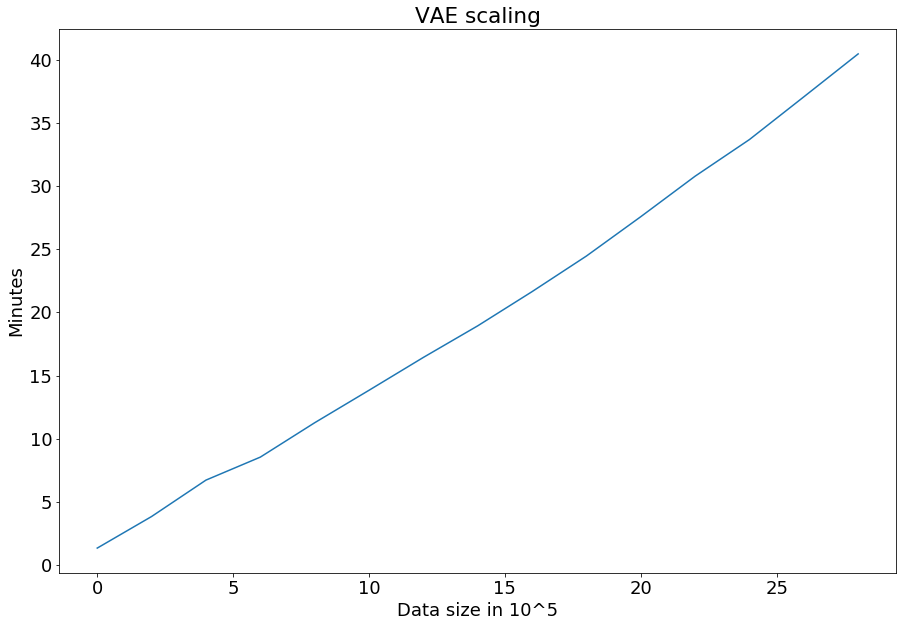

In [38]:
plt.figure(figsize=(15, 10))
plt.title('VAE scaling')
plt.ylabel('Minutes')
plt.xlabel('Data size in 10^5')
plt.plot(data_sizes, total_mins)